In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Do not show warnings
import warnings
warnings.filterwarnings("ignore")

# Read the csv file
file_name = 'SourceFiles\\accepted_2007_to_2018Q3.csv'
df=pd.read_csv(file_name,low_memory=False)

In [2]:
# Print dimensions of df
df.shape

(2132287, 151)

In [3]:
# Value count the response variable loan_status.
df.loan_status.value_counts()

Fully Paid                                             1011841
Current                                                 822105
Charged Off                                             254777
Late (31-120 days)                                       22852
In Grace Period                                          12458
Late (16-30 days)                                         5442
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     32
Name: loan_status, dtype: int64

In [4]:
#Keep only fully paid and charged off because the rest of them cannot be used to make predictions on the probability of
# a loan to be charged off
df = df.loc[(df.loan_status=='Fully Paid') | (df.loan_status=='Charged Off')]

# Print the ratio of fully paid and charged off to all samples in df
df.loan_status.value_counts(normalize=True)

Fully Paid     0.798853
Charged Off    0.201147
Name: loan_status, dtype: float64

In [5]:
# Print dimensions of df after removing the useless samples.
df.shape

(1266618, 151)

### About 80% of the loans in the dataframe are fully paid. Charged off loans form about 20% of the loans.

In [6]:
# Reset index of the dataframe
df.reset_index(drop=True,inplace=True)

In [7]:
# id is unique in each row. Check if there is any duplicate rows by checking if there is any duplicate ids
df.id.value_counts().head(3)

124971924    1
93900473     1
135082532    1
Name: id, dtype: int64

In [8]:
# Remove id from df since it will not help in the proccess of building the predicting model because it has unique value
# in each row
del df['id']

#### Features such as collection recovery fee, last payment amount, and features related to hardship and settlement which change or may change during the loan payment cannot help Lending Club make predictions on the ability of the applicant to pay back the loan at the time the application is received. Therefore, only features such as zip code which are available to Lending Club at the time of processing an application are kept. Interest rate is only available once the application is approved but it does not change during the loan payment, hence, it will be kept too.

#### There are many features in the DataFrame such as number of installment accounts opened in past 12 months which are not clear if they are referring to the time the table was created or the time the application was approved. The latter scenario is assumed and these features are kept.

In [9]:
# Accoridng to my understanding of features and based on the reasoning above, the following list of features are removed 
removal_list = ['collection_recovery_fee','last_credit_pull_d','last_fico_range_high','last_fico_range_low','last_pymnt_amnt',
               'last_pymnt_d','next_pymnt_d','out_prncp','out_prncp_inv','recoveries','total_pymnt','total_pymnt_inv',
                'total_rec_int','total_rec_late_fee','total_rec_prncp','hardship_flag','hardship_type','hardship_reason',
                'hardship_status','deferral_term','hardship_amount','hardship_start_date','hardship_end_date',
                'payment_plan_start_date','hardship_length','hardship_dpd','hardship_loan_status',
                'orig_projected_additional_accrued_interest','hardship_payoff_balance_amount','hardship_last_payment_amount',
                'debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date','settlement_amount',
                'settlement_percentage','settlement_term']

# Remove features in removal_list from the dataframe
df.drop(removal_list,axis=1,inplace=True)

In [10]:
len(removal_list)

37

In [11]:
# Print number of remaining columns
len(df.columns)

113

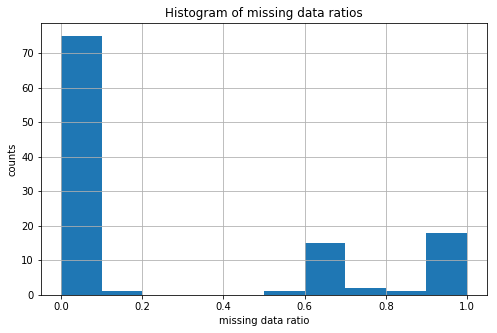

In [12]:
# Find out the ratio of null values in each column and plot the histogram of the ratios across all columns
plt.figure(figsize=(8,5))
mean_series = df.isnull().mean()
mean_series.plot.hist(grid=True)
plt.title('Histogram of missing data ratios')
plt.xlabel('missing data ratio')
plt.ylabel('counts')
plt.show()

In [13]:
# There are two groups of missing data ratios, below 20% and beyond 50%. Print the second category
np.round(mean_series[mean_series>=0.2].sort_values(),3)

mths_since_last_delinq                 0.505
max_bal_bc                             0.632
inq_fi                                 0.632
open_rv_24m                            0.632
open_rv_12m                            0.632
total_bal_il                           0.632
open_act_il                            0.632
open_il_12m                            0.632
open_il_24m                            0.632
inq_last_12m                           0.632
total_cu_tl                            0.632
open_acc_6m                            0.632
all_util                               0.632
mths_since_rcnt_il                     0.642
mths_since_recent_revol_delinq         0.666
il_util                                0.681
mths_since_last_major_derog            0.738
mths_since_recent_bc_dlq               0.763
mths_since_last_record                 0.830
desc                                   0.903
annual_inc_joint                       0.983
dti_joint                              0.983
verificati

#### 'desc' is loan description provided by the borrower and null element means no description was provided. Since 90% is missing it is better to remove it
#### 'member_id' is missing across all samples and must be removed

In [14]:
df.drop(['desc','member_id'],axis=1,inplace=True)

#### The remaining features with high missing ratio can be divided into two groups: Features specific to primary and secondary applicants. The latter group are only defined for joint applications and have null value across individual applications because only joint applications have a secondary applicant. 

#### Regarding the features which are not specific to the primary applicant, an expert from Lending Club could tell if a null element means 0 or the data is actually missing. Since there is no access to an expert, if 0 values exist in these features, equivalency of null value and 0 cannot be assumed.

In [15]:
# Create the list of features with high ratio of null values which are specific to the primary applicant
list_non_joint = ['mths_since_last_delinq','max_bal_bc','inq_fi','open_rv_24m','open_rv_12m','total_bal_il','open_act_il',
                  'open_il_12m','open_il_24m','inq_last_12m','total_cu_tl','open_acc_6m','all_util','mths_since_rcnt_il',
                  'mths_since_recent_revol_delinq','il_util','mths_since_last_major_derog','mths_since_recent_bc_dlq',
                  'mths_since_last_record']

# Print the number of 0 elements of each feature in list_non_joint
for feature in list_non_joint:
    print('Number of 0 elements of {} is {}'.format(feature,(df[feature]==0).sum()))

Number of 0 elements of mths_since_last_delinq is 1679
Number of 0 elements of max_bal_bc is 12165
Number of 0 elements of inq_fi is 224343
Number of 0 elements of open_rv_24m is 60947
Number of 0 elements of open_rv_12m is 151404
Number of 0 elements of total_bal_il is 48337
Number of 0 elements of open_act_il is 51114
Number of 0 elements of open_il_12m is 228474
Number of 0 elements of open_il_24m is 106333
Number of 0 elements of inq_last_12m is 109927
Number of 0 elements of total_cu_tl is 240405
Number of 0 elements of open_acc_6m is 187186
Number of 0 elements of all_util is 954
Number of 0 elements of mths_since_rcnt_il is 226
Number of 0 elements of mths_since_recent_revol_delinq is 914
Number of 0 elements of il_util is 2457
Number of 0 elements of mths_since_last_major_derog is 251
Number of 0 elements of mths_since_recent_bc_dlq is 547
Number of 0 elements of mths_since_last_record is 679


#### Because 0 values already exist in the features above, null values mean data is missing. Therefore, the features have more than 50% missing values. Features with such a high rate of missing values must be kept only if they are of quite high importance in the process of reviewing a loan application. Again, an expert in finance could help with that. Because there is no access to an expert, and also, the number of these features is not too high compared to the total number of features, it is safer to remove them.

In [16]:
df.drop(list_non_joint,axis=1,inplace=True)

In [17]:
# Before working on the features specific to the secondary applicant, check the ratio of individual and joint applications.
df.application_type.value_counts(normalize=True)

Individual    0.983418
Joint App     0.016582
Name: application_type, dtype: float64

In [18]:
# Create a list of features specific to the secondary applicant
joint_list = ['annual_inc_joint','dti_joint','verification_status_joint','revol_bal_joint','sec_app_fico_range_low',
              'sec_app_fico_range_high','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc',
              'sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts',
              'sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog']

# Make sure the columns specific to the secondary applicant have null values across individual applications
df.loc[df.application_type=='Individual',joint_list].notnull().any()

annual_inc_joint                       False
dti_joint                              False
verification_status_joint              False
revol_bal_joint                        False
sec_app_fico_range_low                 False
sec_app_fico_range_high                False
sec_app_earliest_cr_line               False
sec_app_inq_last_6mths                 False
sec_app_mort_acc                       False
sec_app_open_acc                       False
sec_app_revol_util                     False
sec_app_open_act_il                    False
sec_app_num_rev_accts                  False
sec_app_chargeoff_within_12_mths       False
sec_app_collections_12_mths_ex_med     False
sec_app_mths_since_last_major_derog    False
dtype: bool

#### Less than 2% of the loans are joint (‘application_type’ feature determines if a loan is joint or individual). Features specific to the secondary applicant have null values across individual applications, and therefore, they have more than 98% missing values. Consequently, they should not be removed solely because of high ratio of null elements. They could be removed only if the ratio of null elements across joint applications is significant. 

In [19]:
# Check the ratio of null elements of the features specific to the secondary applicant across joint applications
np.round(df.loc[df.application_type=='Joint App',joint_list].isnull().mean(),3)

annual_inc_joint                       0.000
dti_joint                              0.000
verification_status_joint              0.005
revol_bal_joint                        0.305
sec_app_fico_range_low                 0.305
sec_app_fico_range_high                0.305
sec_app_earliest_cr_line               0.305
sec_app_inq_last_6mths                 0.305
sec_app_mort_acc                       0.305
sec_app_open_acc                       0.305
sec_app_revol_util                     0.317
sec_app_open_act_il                    0.305
sec_app_num_rev_accts                  0.305
sec_app_chargeoff_within_12_mths       0.305
sec_app_collections_12_mths_ex_med     0.305
sec_app_mths_since_last_major_derog    0.751
dtype: float64

In [20]:
# Only one feature has high ratio of missing values and could be removed
df.drop(['sec_app_mths_since_last_major_derog'],axis=1,inplace=True)

In [21]:
# Print string features
df.loc[:,df.dtypes[df.dtypes=='object'].index].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266618 entries, 0 to 1266617
Data columns (total 21 columns):
term                         1266618 non-null object
grade                        1266618 non-null object
sub_grade                    1266618 non-null object
emp_title                    1187023 non-null object
emp_length                   1193901 non-null object
home_ownership               1266618 non-null object
verification_status          1266618 non-null object
issue_d                      1266618 non-null object
loan_status                  1266618 non-null object
pymnt_plan                   1266618 non-null object
url                          1266618 non-null object
purpose                      1266618 non-null object
title                        1252196 non-null object
zip_code                     1266618 non-null object
addr_state                   1266618 non-null object
earliest_cr_line             1266618 non-null object
initial_list_status          1266618 no

In [22]:
# Value count url
df.url.value_counts().head(3)

https://lendingclub.com/browse/loanDetail.action?loan_id=48634114    1
https://lendingclub.com/browse/loanDetail.action?loan_id=46809678    1
https://lendingclub.com/browse/loanDetail.action?loan_id=91092803    1
Name: url, dtype: int64

In [23]:
# Delete url
del df['url']

In [24]:
# Check the number of remaining columns
len(df.columns)

90

#### Some string features are categorical and some need to be converted to datetime format. For each categorical feature, two plots are shown; a pie plot which shows the percentage of each level of the feature, and a bar plot which shows the distribution of charged-off-to-all-loans ratio across the levels. The two plots provide some insight about the data. Also, if the distribution does not significantly change across different levels of a feature, it indicates the feature does not have a huge impact on the loan status and could be removed.

In [25]:
# First define a function which creates the two pie and bar plots
def two_plots(feature,figsize=(8,4),dataframe=df,label_rotation= 'horizontal'):
    """This function creates two plots for each categorical feature. The first one is a pie plot which shows the percentage of 
    each level of the feature across all samples. The second plot is a bar plot which shows the distribution of the 
    charged-off-to-total-loan ratio across all levels of the categorical feature. The bar plot is sorted based on 
    charged-off-to-total-loan ratio"""
    # Pie plot
    dataframe[feature].value_counts().sort_index().plot.pie(autopct='%1.1f%%',startangle=0,figsize=figsize)
    plt.axis('equal')
    plt.title('Pieplot of {}'.format(feature),y=1.05)
    plt.ylabel('')
    #Bar plot
    dff=dataframe.pivot_table(index = feature, columns='loan_status',values='loan_amnt',aggfunc='count')
    dff['chargedoff_total_ratio']=dff.apply(lambda x:x['Charged Off']/x.sum(), axis=1)
    dff.sort_values(by=['chargedoff_total_ratio'],inplace=True)
    plt.figure(figsize = figsize)
    plt.bar(dff.index,dff['chargedoff_total_ratio'])
    plt.xlabel(feature)
    plt.xticks(rotation=label_rotation)
    plt.ylabel('charged-off to total loan ratio')
    plt.title('Bar plot of {}'.format(feature))
    plt.show()   

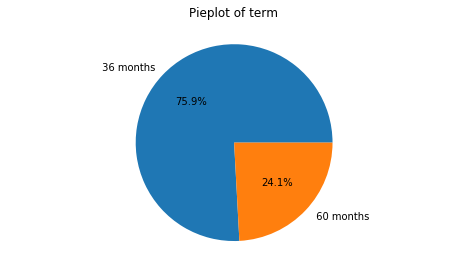

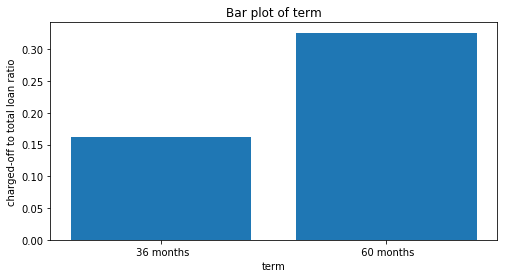

In [26]:
# Run tow_plots on term
two_plots('term')

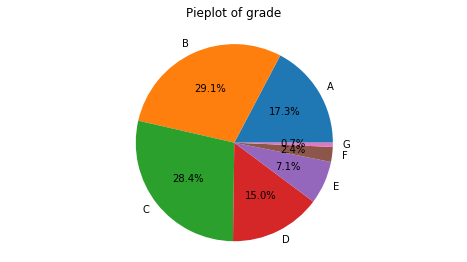

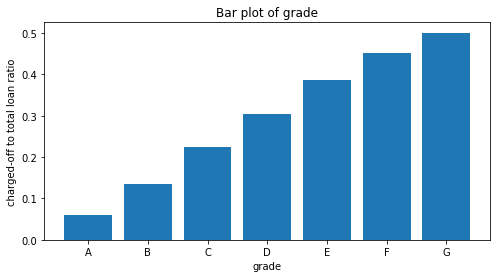

In [27]:
# Run two_plots on grade
two_plots('grade')

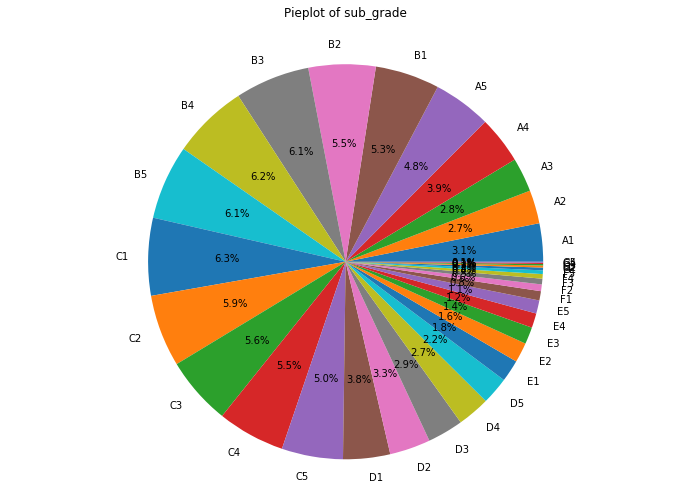

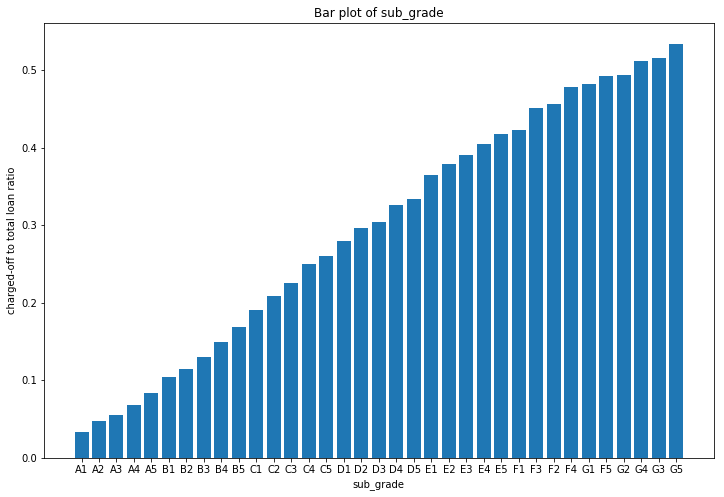

In [28]:
# Run two plots on sub_grade
two_plots('sub_grade',figsize=(12,8))

#### The bar plot of sub grade shows the impact of sub-grades on charge-off-to-total-loan ratio across the grades are quite similar. Therefore, sub_grade could be removed from features

In [29]:
# Remove sub-grades from df
del df['sub_grade']

In [30]:
# Print value counts of emp_title
df.emp_title.value_counts().head(20)

Teacher               19782
Manager               18096
Owner                  9370
Registered Nurse       8197
RN                     7996
Supervisor             7769
Sales                  6967
Driver                 6952
Project Manager        5996
Office Manager         5177
General Manager        4848
Director               4723
manager                4251
owner                  4237
Engineer               4009
President              3833
teacher                3832
driver                 3321
Vice President         3303
Operations Manager     3254
Name: emp_title, dtype: int64

In [31]:
# It can be seen some titles are only different in upper or lower case such as driver and Driver; this issue is fixed
df['emp_title'] = df.emp_title.str.title()

# P.S. There is another problem with the employment title; some titles are redundant or very close to each other, for example, 
# registered nurse and RN are the same. This also could be improved, but due to its complexity, the step is skipped. 

In [32]:
df.emp_title.nunique()

315574

#### There are two many unique values for employment title. Therefore, it is a high cardinality problem. The problem will be addressed later.

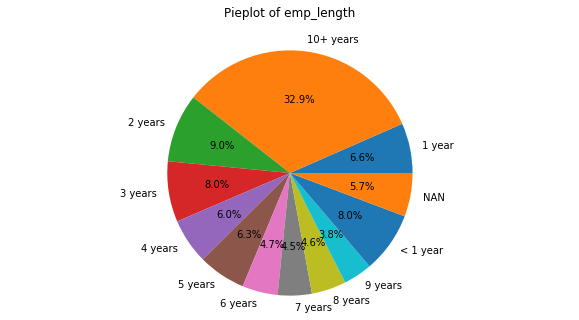

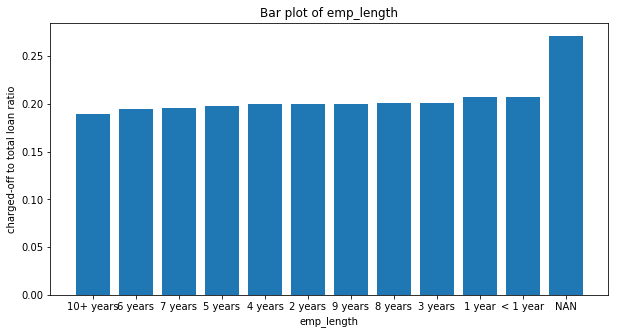

In [33]:
# emp_length has null values. Replace them with NaN
df.emp_length.replace(np.NAN,'NAN',inplace=True)

# Run two_plots on emp_length
two_plots('emp_length',figsize=(10,5))

#### Charged-off-to-total-loan ratio does not significantly change across different employment lengths. Also, the samples with no employment-length value have significantly higher Charged-off-to-total-loan ratio than the samples with specified employment-length. It does not make sense to define NAN as a separate category because all possible employment lengths are covered in other categories. Therefore, it is safer to drop the feature.

In [34]:
# Drop emp_length
df.drop('emp_length',axis=1,inplace=True)

In [35]:
#Run value_counts on home ownership
df.home_ownership.value_counts()

MORTGAGE    627679
RENT        503075
OWN         135425
ANY            247
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [36]:
# Replace NONE and ANY labels with OTHER to simplify the feature 
df.home_ownership.replace(['ANY','NONE'],'OTHER',inplace=True)

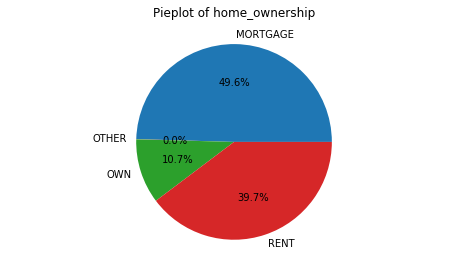

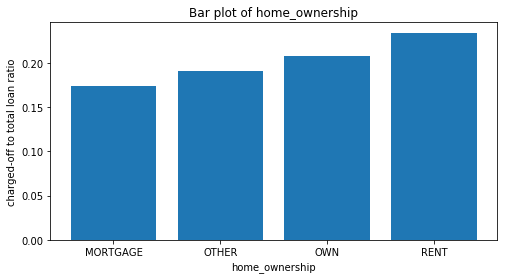

In [37]:
# Run tow_plots on home_ownership
two_plots('home_ownership')

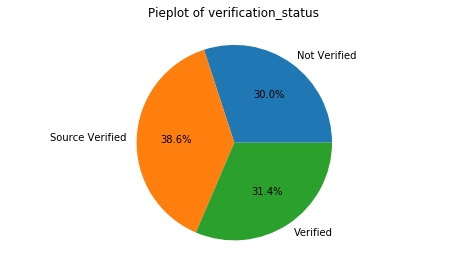

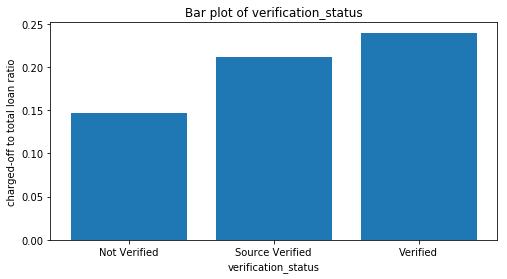

In [38]:
#Run two_plots on verification_status
two_plots('verification_status')

In [39]:
# Print the first three elements of isse_d
df.issue_d.head(3)

0    Dec-2016
1    Dec-2016
2    Dec-2016
Name: issue_d, dtype: object

In [40]:
# Transform issue date to datetime format 
df.issue_d = pd.to_datetime(df.issue_d,format='%b-%Y')

In [41]:
# Save the month of issue date in a new column
df['issue_month'] = df.issue_d.apply(lambda x:x.month).astype('str')

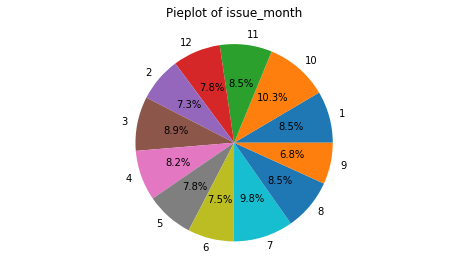

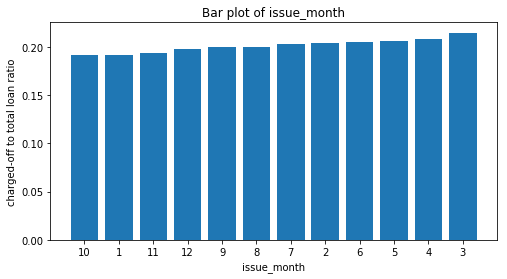

In [42]:
# Run two_plots on issue_month 
two_plots('issue_month')

#### No significant difference in charged-off-to-total-loan ratio between months. So issue_month could be removed

In [43]:
# Remove issue_month
df.drop('issue_month',axis=1,inplace=True)

In [44]:
# Run value counts on payment plan
df.pymnt_plan.value_counts()

n    1266618
Name: pymnt_plan, dtype: int64

In [45]:
# Remove payment plan because it has only one value
df.drop('pymnt_plan',axis=1,inplace=True)

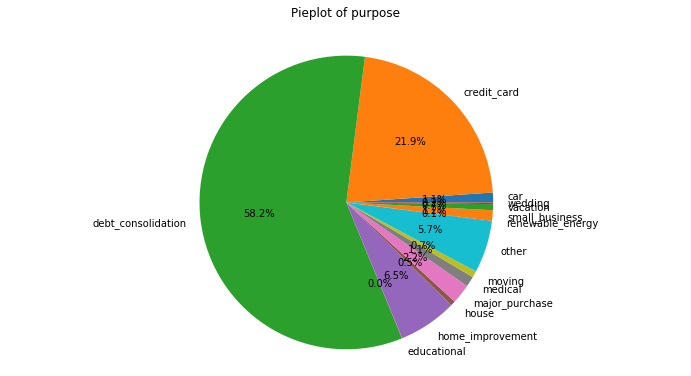

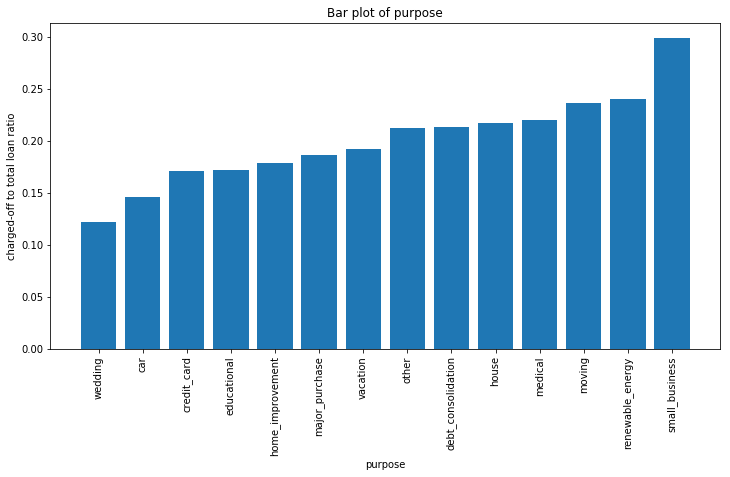

In [46]:
#Run two_plots on purpose
two_plots('purpose',figsize=(12,6),label_rotation='vertical')

In [47]:
# Run value_counts on title
df.title.value_counts().head(20)

Debt consolidation           619241
Credit card refinancing      232590
Home improvement              69631
Other                         61279
Major purchase                22077
Debt Consolidation            15687
Medical expenses              12518
Business                      10978
Car financing                 10350
Vacation                       7459
Moving and relocation          7407
Consolidation                  5350
Home buying                    5340
debt consolidation             4808
Debt Consolidation Loan        3777
Credit Card Consolidation      2346
consolidation                  2163
Personal Loan                  2086
Consolidation Loan             1770
Home Improvement               1757
Name: title, dtype: int64

#### Elements of title are close to elements of purpose. Therefore, purpose is enough and title is removed.

In [48]:
# Remove title from features
del df['title']

In [49]:
# value_count zip codes
df.zip_code.value_counts().head()

945xx    14262
750xx    13677
112xx    13053
606xx    11720
300xx    11381
Name: zip_code, dtype: int64

In [50]:
df.zip_code.nunique()

942

#### Zip code also has high cardinality problem and will be addressed later.

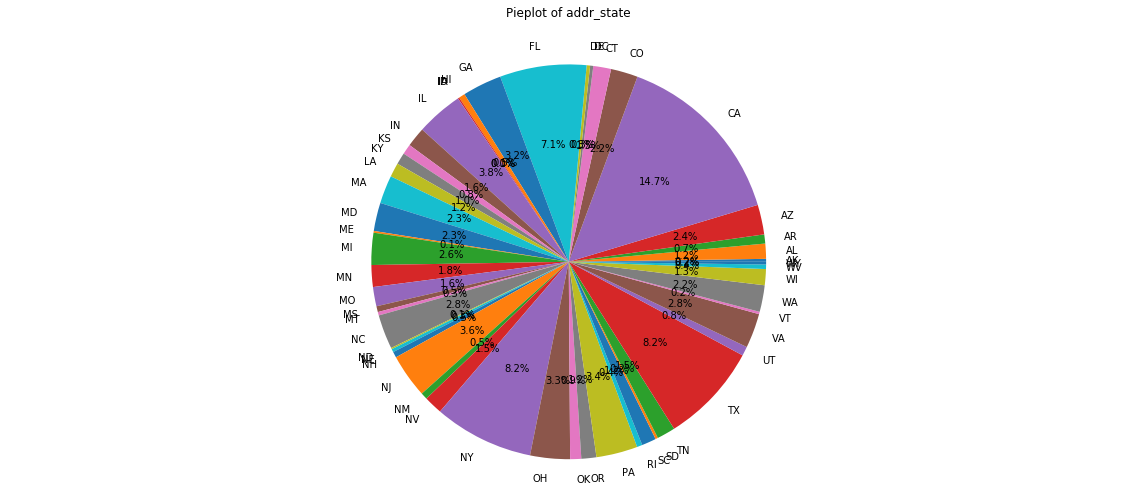

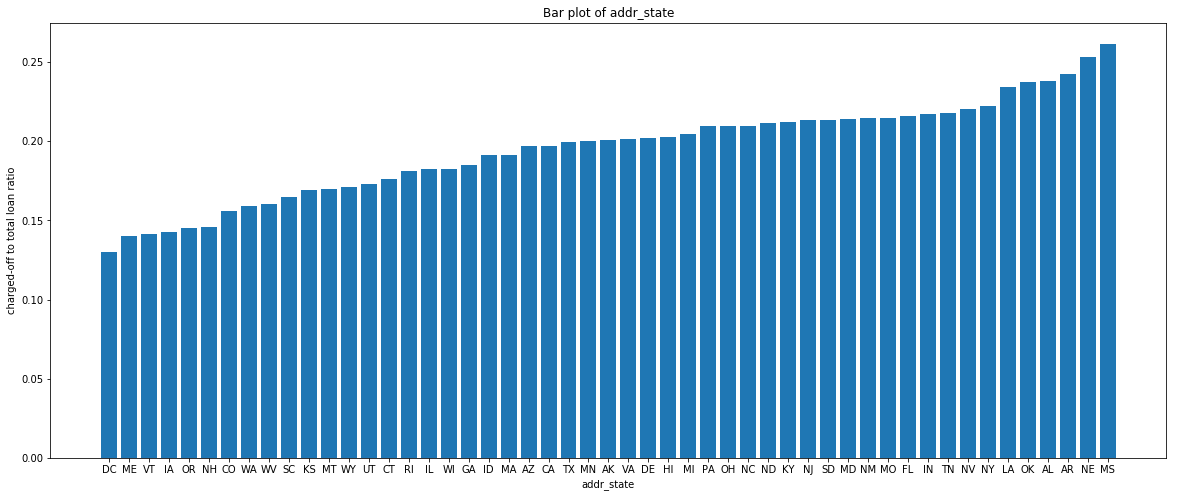

In [51]:
# Run two plots on address state
two_plots('addr_state',figsize=(20,8))

In [52]:
# Transform earliest credit line to datetime format
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line,format='%b-%Y')

In [53]:
# Store number of years since the earliest credit line in a new column
df['years_earliest_cr_line'] = df.issue_d - df.earliest_cr_line
df['years_earliest_cr_line'] = df.years_earliest_cr_line.apply(lambda x:np.round(x.days/365,2))

In [54]:
# Drop earliest_cr_line
df.drop(['earliest_cr_line'],axis=1,inplace=True)

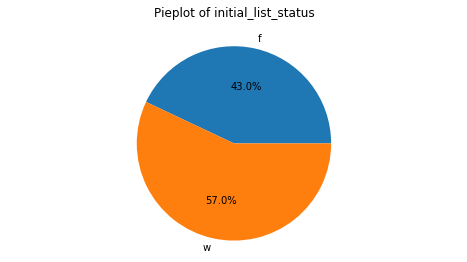

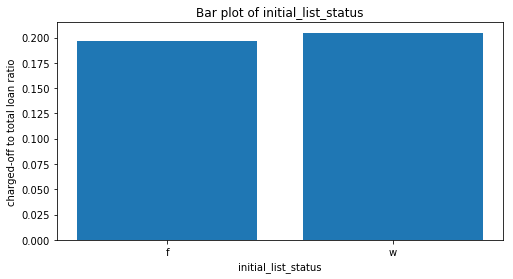

In [55]:
# Run two_plots on initial_list_status
two_plots('initial_list_status')

#### initial_list_status could be removed because it does not significantly impact loan status

In [56]:
# Remove initial_list_status 
df.drop('initial_list_status',axis=1,inplace=True)

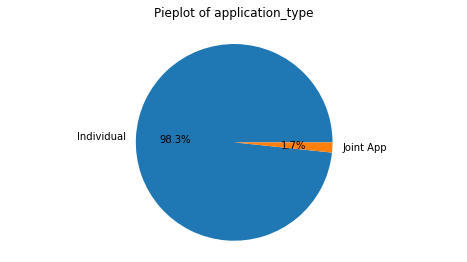

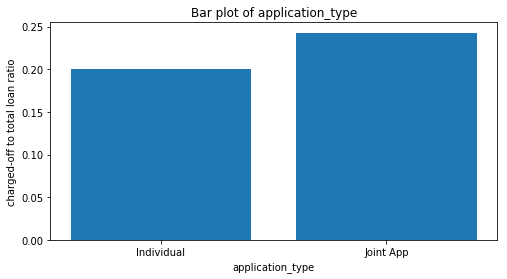

In [57]:
# Run two_plots on application_type
two_plots('application_type')

#### Although a small percentage of loans have joint applicants, they have a higher chance of becoming charged off. Therefore, features specific to the secondary applicant must be handled carefully.

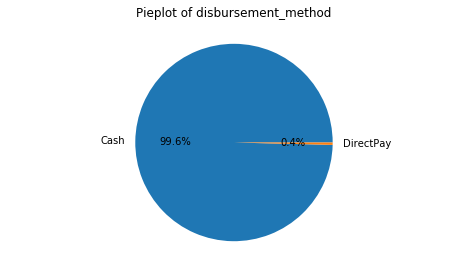

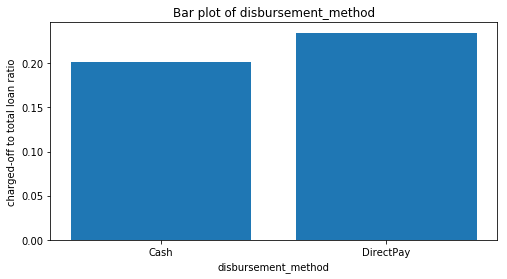

In [58]:
# Run disbursement_method on application_type
two_plots('disbursement_method')

In [59]:
# Work on two features specific to the secondary applicant

# First separate joint applications
df1 = df.loc[df.application_type=='Joint App']

# Print info
df1.loc[:,['verification_status_joint','sec_app_earliest_cr_line']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21003 entries, 182 to 1266609
Data columns (total 2 columns):
verification_status_joint    20892 non-null object
sec_app_earliest_cr_line     14603 non-null object
dtypes: object(2)
memory usage: 492.3+ KB


In [60]:
# Work on verification_status_joint

#Create a copy of df1 and replace null values with NAN
df1_copy = df1.copy()
df1_copy.verification_status_joint.replace(np.NAN,'NAN',inplace=True)

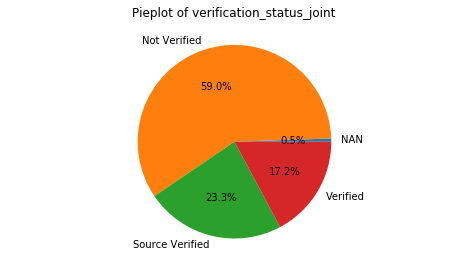

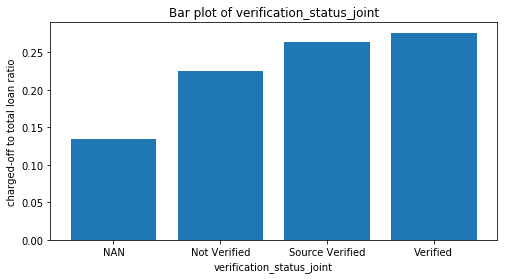

In [61]:
# Run two_plots on verification_status_joint and df1 which contains data for joint applications
two_plots('verification_status_joint',dataframe=df1_copy)

####  Null elements are a quite small percentage of the joint applications; they are filled with forward fill method. 

In [62]:
# Fill null values with ffill method
df1.verification_status_joint.fillna(method='ffill',inplace=True)

In [63]:
# Replace the verification_status_joint column in the original df with the updated column
df.verification_status_joint.update(df1.verification_status_joint)

# Replace the remaining null elements in the column with 'na' since they are referring to individual applications
df.verification_status_joint.replace(np.NAN,'na',inplace=True)

In [64]:
# Work on sec_app_earliest_cr_line

# First change the format from string to datetime 
df1.loc[:,'sec_app_earliest_cr_line'] = pd.to_datetime(df1.sec_app_earliest_cr_line,format='%b-%Y')

# Create a new column which shows number of years since the earliest credit line for the second applicant
df1.loc[:,'sec_app_years_earliest_cr_line'] = df1.issue_d - df1.sec_app_earliest_cr_line
df1.loc[:,'sec_app_years_earliest_cr_line'] = df1.loc[:,'sec_app_years_earliest_cr_line'].apply(lambda x:np.round(x.days/365,2))

# Fill NA with 0.
df1.loc[:,'sec_app_years_earliest_cr_line'].replace(np.NAN,0,inplace=True)

In [65]:
# Add the new column to the original dataframe
df['sec_app_years_earliest_cr_line'] = df1['sec_app_years_earliest_cr_line']

In [66]:
# Remove issue_d and sec_app_earliest_cr_line from df
df.drop(['issue_d','sec_app_earliest_cr_line'],axis=1,inplace=True)

#### In order to address the high cardinality problem of ‘emp_title’ and 'zip_code', they are converted to numerical features with a method similar to weight of evidence. In weight of evidence method, the assigned value to each level of a categorical feature is ln((Pi/TP)/(Ni/TN)) where Pi and Ni are the number of positive and negative response variable for the level, and TP and TN are total positive and negative samples. Since none of the numerical features in the dataframe has negative values, natural logarithm is not applied and the ratio (Pi/TP)/(Ni/TN) is used to convert the features to numerical ones. 

In [67]:
# Define woe function which transforms emp_title and zip_code features to numerical features based on a method 
# similar to weight of evidence

def woe(dataframe=df):
    """In order to fix the cardinality problem, this function is introduced to transform  emp_title and zip_code to numerical
    features according to weight of evidence method but without the natural logarithm """
    
    df_copy = dataframe.copy()
    TP = (dataframe.loan_status == 'Charged Off').sum()
    TN = (dataframe.loan_status == 'Fully Paid').sum()
    for feature in ['emp_title','zip_code']:
        df_pivot= dataframe.pivot_table(index = feature, columns='loan_status',values='loan_amnt',aggfunc='count')
        # fillna returns NaN instead of 0. Null values are replaced with 0
        df_pivot.fillna(0,inplace=True)
        #Pi = 'Charged Off' column in df_pivot
        #Ni = 'Fully Paid' column in df_pivot
        df_pivot['woe'] = df_pivot.apply(lambda x: max(x['Charged Off'],1)*TN/(max(x['Fully Paid'],1)*TP) ,axis=1) 
        # Added max to avoid 0 in nominator and denominator
        list1 = df_pivot.index.tolist()
        list2 = df_pivot.woe.tolist()
        dictionary_map = dict(zip(list1,list2))
        df_copy[feature] = df_copy[feature].map(dictionary_map)
    return df_copy

In [68]:
# Run woe on emp_title and zip_code 
df = woe(df)

#### Ideally, before transforming 'emp_title' and 'zip_code' to numerical variables, the dataset should have been splitted into training and test set and transformation should have been implemented only on training set. Since the correlation of numerical variables will be investigated later, and also in order to simplify the process of building the predicting model, the transformation is applied on the entire dataset.

In [69]:
# Check if object features have any missing values
df.loc[:,df.dtypes[df.dtypes=='object'].index].isnull().any()

term                         False
grade                        False
home_ownership               False
verification_status          False
loan_status                  False
purpose                      False
addr_state                   False
application_type             False
verification_status_joint    False
disbursement_method          False
dtype: bool

#### No categorical features have any missing values.

In [70]:
# Print number of columns
len(df.columns)

84

In [71]:
# Save the wrangled data to a csv file
df.to_csv('df_wrangled.csv',index=False)

In [72]:
# Print columns of df
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_title', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl